In [49]:
import pandas as pd
import pyspark as ps
from pyspark.sql import SparkSession
import matplotlib.pyplot as mp
from pyspark.sql.functions import *
import os
import re
from pyspark.sql.types import StringType
import numpy as np
import requests
from pprint import pp

In [3]:
# Creating Spark Session
spark = SparkSession.builder.appName('SBA 350').getOrCreate()
# Reading /loading the Dataset from JSON file, SPARK by defualt infersSchema for JSON files; only need headers parameter typically for csv files
customer_spark = spark.read.load("cdw_sapp_customer.json", format="json")
branch_spark = spark.read.load("cdw_sapp_branch.json", format= "json")
credit_spark = spark.read.load("cdw_sapp_credit.json", format= "json")

In [ ]:
# credit_spark.show()
credit_spark.dtypes
# [('BRANCH_CODE', 'bigint'),
#  ('CREDIT_CARD_NO', 'string'),
#  ('CUST_SSN', 'bigint'),
#  ('DAY', 'bigint'),
#  ('MONTH', 'bigint'),
#  ('TRANSACTION_ID', 'bigint'),
#  ('TRANSACTION_TYPE', 'string'),
#  ('TRANSACTION_VALUE', 'double'),
#  ('YEAR', 'bigint')]

In [ ]:
# branch_spark.show()
branch_spark.dtypes
# [('BRANCH_CITY', 'string'),
#  ('BRANCH_CODE', 'bigint'),
#  ('BRANCH_NAME', 'string'),
#  ('BRANCH_PHONE', 'string'),
#  ('BRANCH_STATE', 'string'),
#  ('BRANCH_STREET', 'string'),
#  ('BRANCH_ZIP', 'bigint'),
#  ('LAST_UPDATED', 'string')]

In [25]:

print(customer_spark.dtypes)
#[('APT_NO', 'string'),
#  ('CREDIT_CARD_NO', 'string'),
#  ('CUST_CITY', 'string'),
#  ('CUST_COUNTRY', 'string'),
#  ('CUST_EMAIL', 'string'),
#  ('CUST_PHONE', 'bigint'),
#  ('CUST_STATE', 'string'),
#  ('CUST_ZIP', 'string'),
#  ('FIRST_NAME', 'string'),
#  ('LAST_NAME', 'string'),
#  ('LAST_UPDATED', 'string'),
#  ('MIDDLE_NAME', 'string'),
#  ('SSN', 'bigint'),
#  ('STREET_NAME', 'string')]
print(customer_spark.count())
print(customer_spark.distinct().count())

[('APT_NO', 'string'), ('CREDIT_CARD_NO', 'string'), ('CUST_CITY', 'string'), ('CUST_COUNTRY', 'string'), ('CUST_EMAIL', 'string'), ('CUST_PHONE', 'bigint'), ('CUST_STATE', 'string'), ('CUST_ZIP', 'string'), ('FIRST_NAME', 'string'), ('LAST_NAME', 'string'), ('LAST_UPDATED', 'string'), ('MIDDLE_NAME', 'string'), ('SSN', 'bigint'), ('STREET_NAME', 'string')]
952
952


In [4]:

# tan_customer = customer_spark['FIRST_NAME', 'MIDDLE_NAME', 'LAST_NAME', 'STREET_NAME','APT_NO', 'CUST_PHONE']
# customer_spark.createOrReplaceTempView('customer')


def tran_cust_title_case(df, column_name):
    return df.withColumn(column_name,initcap(col(column_name)))
def tran_cust_lower_case(df, column_name):
    return df.withColumn(column_name,lower(col(column_name)))
def concat_cust_street_apt(df, col1, col2):
    #concat_ws concatenates multiple string columns 
    return df.withColumn('FULL_STREET_ADDRESS', concat_ws(',', col(col1), col(col2)))
#the cust_phone doesn't have an area code, need to rectify somehow
def tran_phone_num(df, column_name):
    return df.withColumn(column_name, concat(lit('('), 
                                             substring(col(column_name), 1, 3),
                                             lit(')'),
                                             substring(col(column_name), 4, 3),
                                             lit('-'),
                                             substring(col(column_name), 7, 4))
                                             .cast('string'))
#checks if the branches zip is null and defaults it to 99999, and if it isn't it returns the branches zip
def tran_branch_zip(df):
    return df.withColumn('BRANCH_ZIP', when(col('BRANCH_ZIP').isNull(), lit(99999)).otherwise(col('BRANCH_ZIP')))

#match cust state to branch state and slice branch phone 3-5 (last included?) to append to cust phone after 2nd element
#first left join the cust df and the branch df on their respective states like in sql
#getting duplicate rows are created for each row the join operation matches
custJoinbranch = customer_spark.join(branch_spark, customer_spark['CUST_STATE'] == branch_spark['BRANCH_STATE'], 'left')

# Updating the customer phone by appending a sliced portion of the branch phone
customer_fix = custJoinbranch.withColumn('CUST_PHONE', concat(col('CUST_PHONE').substr(1, 2), col('BRANCH_PHONE').substr(3, 3), col('CUST_PHONE').substr(3, 7)))
unwanted_columns = branch_spark.columns
#asterisk unpacks the columns from branch_spark so drop doesn't receive it all as a single argument and understands they're
# individual column names. Drop duplicates on cust_ssn so different family members living together aren't dropped. W/o the column 
# selection we'd have 3700 distinct entries vs the 952 we started with
customer_fix = customer_fix.drop(*unwanted_columns).dropDuplicates(['SSN'])

# concat the day, month, year columns into a TIMEID (YYYYMMDD)
def tran_to_timeid(df, day, month, year):
    # first concat the columns so you can use the to_date function so its format won't match the 
    # other tables. Need to lpad the month and day values so not to throw error when parsing to
    # to_date. The 2 represents the desired length of the string and the 0 is what we're left-padding 
    # with. Can't even do what the mapping logic wants YYYYMMDD
    date_string = concat(
        col(year),
        lpad(col(month), 2, '0'),
        lpad(col(day), 2, '0'))
    return df.withColumn('TIMEID', to_date(date_string, 'yyyyMMdd'))

In [4]:
print(customer_spark.count())
print(customer_spark.distinct().count())
print(branch_spark.count())
print(branch_spark.distinct().count())
print(custJoinbranch.count())
print(custJoinbranch.distinct().count())
print(customer_fix.count())
print(customer_fix.distinct().count())
# print(customer_fix1.count())
# print(customer_fix1.distinct().count())

952
952
115
115
5665
5665
952
952


In [5]:
#transforming the specified columns, from the mapping document, of the extracted customer df into new df
# tran_cust_spark = customer_spark.transform(tran_cust_title_case, 'FIRST_NAME')\
tran_cust_spark = customer_fix.transform(tran_cust_title_case, 'FIRST_NAME')\
.transform(tran_cust_lower_case, 'MIDDLE_NAME')\
.transform(tran_cust_title_case, 'LAST_NAME')\
.transform(concat_cust_street_apt, 'APT_NO', 'STREET_NAME')\
.drop('STREET_NAME', 'APT_NO')\
.transform(tran_phone_num, 'CUST_PHONE')


customer_spark.show()
tran_cust_spark.show()


+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States| WDunham@exam

In [6]:
print(tran_cust_spark.count())
print(tran_cust_spark.distinct().count())
print(tran_cust_spark.dtypes)

952
952
[('CREDIT_CARD_NO', 'string'), ('CUST_CITY', 'string'), ('CUST_COUNTRY', 'string'), ('CUST_EMAIL', 'string'), ('CUST_PHONE', 'string'), ('CUST_STATE', 'string'), ('CUST_ZIP', 'string'), ('FIRST_NAME', 'string'), ('LAST_NAME', 'string'), ('MIDDLE_NAME', 'string'), ('SSN', 'bigint'), ('FULL_STREET_ADDRESS', 'string')]


In [6]:
#transforming the specified columns, from the mapping document, of the extracted branch df into new df
#just need to transform the branch_zip if the source value is null load default (99999) value else direct move
#and branch_phone change the format of phone number to (xxx)xxx-xxxx
tran_branch_spark = branch_spark.transform(tran_branch_zip)\
.transform(tran_phone_num, 'BRANCH_PHONE')

branch_spark.show()
tran_branch_spark.show()



+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|       Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|  Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|      Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL|   Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|        14th Street|     19406|2018-04-18T16:51:...|
|         Paters

In [16]:
#have to set sparks configuration to legacy to stop getting error from parsing the to_date, throws null now if it isn't valid
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
tran_branch_spark.select('last_updated').show(truncate=False)

+-----------------------------+
|last_updated                 |
+-----------------------------+
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
|2018-04-18T16:51:47.000-04:00|
+-----------------------------+
only showing top 20 rows



In [22]:
# date_syntax = tran_branch_spark.select('last_updated')
# date_column = to_date(date_syntax)
# date_format_syntax = date_column.cast(StringType()).expr._jc.getDateFormat()

2018-04-18T16:51:47.000-04:00


In [7]:
#transforming the specified columns, from the mapping document, of the extracted credit df into new df
#just need to convert/concat the day, month, year columns into a TIMEID (YYYYMMDD)
#is there a way to use a timestamp and not just concat? is there an easier way?
tran_credit_spark = credit_spark.transform(tran_to_timeid, 'DAY', 'MONTH', 'YEAR')\
.drop('DAY','MONTH','YEAR')

credit_spark.show()
tran_credit_spark.show()


+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|
|        164|4210653349028689|123459988| 28|    5|             6|       Education|             6.89|2018|
|        119|4210653349028689|123459988| 19|  

In [8]:
#create and populate the requisite tables in SQL db creditcard_capstone
tran_cust_spark.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                     user="root",
                                     password="password",
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                     dbtable="CDW_SAPP_CUSTOMER", 
                                     ).mode('overwrite').save()

tran_branch_spark.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                     user="root",
                                     password="password",
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                     dbtable="CDW_SAPP_BRANCH", 
                                     ).mode('overwrite').save()

tran_credit_spark.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                     user="root",
                                     password="password",
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                     dbtable="CDW_SAPP_CREDIT_CARD", 
                                     ).mode('overwrite').save()

In [9]:
# Read the data from the MySQL table
cust_sql = spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                             user="root",
                                             password="password",
                                             url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                             dbtable="CDW_SAPP_CUSTOMER"
                                             ).load()
branch_sql = spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                             user="root",
                                             password="password",
                                             url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                             dbtable="CDW_SAPP_BRANCH"
                                             ).load()
credit_sql = spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                             user="root",
                                             password="password",
                                             url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                             dbtable="CDW_SAPP_CREDIT_CARD"
                                             ).load()

# Display the contents of the DataFrame
# cap_spark.show()


Terminal Application

Let's define a simple terminal app that we can make in this notebook. Greeter will:

Always display a title bar at the top of the screen, showing the name of the app that is running.
Offer you three choices:
    Enter a name.
        If the program knows that name, it will print a message saying something like "Hello, old friend."
        If the program does not know that name, it will print a message saying something like, "It's nice to meet you. I will remember you."
            The next time the program hears this name, it will greet the person as an old friend.
    See a list of everyone that is known.
    Quit.
The program will remember people, even after it closes.
The program may list the number of known people in the title bar.


Now we will go over a few things we need to know in order to build this app, and then we will build it.

In [ ]:
### FUNCTIONS ###

def display_title_bar():
    # Clears the terminal screen, and displays a title bar.
    os.system('cls')
              
    print("\t**********************************************")
    print("\t***  Welcome to Chad's Final Project!  ***")
    print("\t**********************************************")

def get_user_choice():
    #1-3 are TRANSACTION DETAILS MODULE
    #next option to order by day and descending order(maybe make it optional for ascending as well?)
    print("[1] Display transactions by customers given zip code and date?.")
    
    #next level give them the choice of options education, entertainment, healthcare, grocery, test,
    #gas, bills
    print("[2] Display the number and total values of tranactions of a given TYPE.")
    print("[3] Display the number and total values of transactions for branches of a given STATE.")
    
    
    #4-7 are CUSTOMER DETAILS
    print("[4] Check account details of an existing customer.")
    print("[5] Modify the details of an existing customer's account.")
    print("[6] Generate a monthly bill for a credit card number, given the month and year.")
    #order by year, month, day in descending order(add ascending?)
    print("[7] Display the transactions of a customer between two given dates.")
    
    
    print("[8] Plot which transaction type has a high rate of transactions.")
    print("[9] Plot which state has a high number of customers.")
    print("[10] Plot the sum of all transactions for the top 10 customers, and which customer"
          " has the highest transaction amount. ")
    
    print("[q] Quit.")
    
    return input("What would you like to do? ")

#1st choice
#Used to display the transactions made by customers living in a given zip code for a given month and
#  year. Order by day in descending order.

#column date data, that isnt in the tran_credit_spark, is formatted in ISO 8601 standard 
#ie 2018-04-18T16:51:47.000-04:00 (YYYY-MM-DD T HH:MM:SS.SSS - TIMEZONE)
def disp_tran_by_cust_zip(zip, y, m):
    #join cust_sql with credit_sql on cust_ssn; zip is an int and 
    custJoinCredit =  cust_sql.join(credit_sql, cust_sql.SSN == credit_sql.CUST_SSN, 'left')
    #drop the ssn column and specifically the credit_sql.credit_card_no to avoid duplicates in the show object
    # could do the cust_spark one, depends on where you want the credit_card_no column to be on the table
    #just have to do .sort(desc('TIMEID')), will auomatically put it in desc by year, month, day. .sort() is the same as .orderBy() 
    custJoinCredit = custJoinCredit.drop('SSN', credit_sql.CREDIT_CARD_NO)
    custJoinCredit.filter((custJoinCredit.CUST_ZIP == zip) & 
                          (year(custJoinCredit.TIMEID) == y) &
                          (month(custJoinCredit.TIMEID) == m)).sort(desc('TIMEID')).show()
    # print(len(custJoinCredit.columns))

#2nd choice
# Used to display the number and total values of transactions for a given type. 
def disp_tran_total_by_type(t_type):
    #have to convert to int cause input by default is string type
    n_rows = int(input("How many rows would you like displayed? ")) 
    credit_sql.filter(credit_sql.TRANSACTION_TYPE == t_type).show(n=n_rows)

#3rd choice
# Used to display the total number and total values of transactions for branches in a given state.    
def disp_tran_total_by_branch_state(state):
    #need to join branch_sql w/ credit_sql on branch_code; then filter by state and show the total
    # value and category of all transactions
    ttypes = ['Education', 'Entertainment', 'Healthcare', 'Grocery', 'Test', 'Gas', 'Bills']
    branchJoinCredit = branch_sql.join(credit_sql, branch_sql.BRANCH_CODE == credit_sql.BRANCH_CODE, 'left')
    #set it to a new variable for further filtering
    b = branchJoinCredit.filter(branchJoinCredit.BRANCH_STATE == state)
    b.show()
    for trans in ttypes:
        #filtering transactions column for only the current type from the ttypes list; then taking the sum 
        #of them using the aggregate function; use collect to return the results as a list so we can set the
        #sum_value variable equal to it; need the list indeces at the end so it doesn't look all wonky; its a
        #single aggregated value so only need [0][0] with no incrementation required in loop
        #have to round because defulat is 6 decimals for w/e reason
        # sum_value = b.filter(b.TRANSACTION_TYPE == trans).agg({'TRANSACTION_VALUE': 'sum'}).collect()[0][0]
        sum_value = b.filter(b.TRANSACTION_TYPE == trans)\
        .select(round(sum(b.TRANSACTION_VALUE), 2)).collect()[0][0]
        print(f"Total value of {trans} transactions in {state}: ${sum_value}")
    print()

#4th choice
# Used to check the existing account details of a customer.
def check_cust_exist(cust_ssn):
    #simple show from cust_sql
    cust_sql.filter(cust_sql.SSN == cust_ssn).show()

#5th choice
#  Used to modify the existing account details of a customer.
def modify_cust_account(cust_ssn):
    attributes = []
    for column in cust_sql:
        attributes.append(column)
    cust_sql.select(cust_sql.SSN == cust_ssn)
    print()

#6th choice
# Used to generate a monthly bill for a credit card number for a given month and year. 
#column date data, that isnt in the tran_credit_spark, is formatted in ISO 8601 standard 
#ie 2018-04-18T16:51:47.000-04:00 (YYYY-MM-DD T HH:MM:SS.SSS - TIMEZONE)
# def gen_monthly_bill_by_card_number(card, year):
def gen_monthly_bill_by_card_number(card, y, m):
    # just have to access the credit_sql
    credit_sql.filter((year(credit_sql.TIMEID) == y ) & 
                      (month(credit_sql.TIMEID) == m ) & 
                      (credit_sql.CREDIT_CARD_NO == card)).show()
    #have to round the sum because for w/e reason w/o it it somehow makes it 6 decimals
    # gave alias for legibility 
    credit_sql.filter((year(credit_sql.TIMEID) == y ) & 
                      (month(credit_sql.TIMEID) == m ) & 
                      (credit_sql.CREDIT_CARD_NO == card))\
    .select(round(sum(credit_sql.TRANSACTION_VALUE), 2).alias('Total Monthly Bill')).show()
   
#7th choice
# Used to display the transactions made by a customer between two dates.
# Order by year, month, and day in descending order.
# just using the credit_sql again. Going to use range, which is between in pyspark. So we're filtering
# by cust_ssn then betweening by sd - ed; just have to do .sort(desc('TIMEID')), will auomatically
# put it in desc by year, month, day. 
def disp_tran_by_cust_between_given_dates(cust_ssn, sd, ed):
    credit_sql.filter((credit_sql.CUST_SSN == cust_ssn) & credit_sql.TIMEID.between(sd,ed))\
    .sort(desc('TIMEID')).show()

#8th choice
# Find and plot which transaction type has a high rate of transactions. 
# just need to access the credit_sql to make visualization; had to import .pyplot specifically
#dunno why importing all of matplotlib doesn't work
def plot_high_tran_type():
    # have to use toPandas to be able to plot; use groupby to group the transaction types together
    panda_credit = credit_sql.toPandas()
    # panda_credit = tran_credit_spark.toPandas()
    # then run the count of transactions of ea type; then run the sum of their values; 
    # use dot notation(instead of bracket notation) to access
    # TRANSACTIONS_VALUE for flex points
    
    # adding the .max() and removing the sort_values does print the highes sum which is 351405.28 but
    # not its name which is Bills; have to do .size().max() to get just the numerical value of the highest transaction type. 
    p_sum = panda_credit.groupby('TRANSACTION_TYPE').TRANSACTION_VALUE.sum()
    p_count = panda_credit.groupby('TRANSACTION_TYPE').size()
    p_highest = panda_credit.groupby('TRANSACTION_TYPE').size().max()
    #have to set the idmax to a variable, can't do it in same line above or call it as panda_sum.idmax() w/o
    # removing the .max() from it since that makes it a single value and there'd be no idmax that way
    p_id = p_sum.idxmax()
    p_max = p_sum.max()
    print(f'The transaction type with the highest count is {p_id}, with a total count of {p_highest} summing up to ${p_max}')
    mp.plot(p_count)
    mp.xlabel('Transaction Types')
    mp.ylabel('Total count of each Transaction')
    mp.title('Total count of transactions by type')
    mp.xticks(rotation=45)
    mp.show()

# 9th choice
#  Find and plot which state has a high number of customers.
def plot_high_cust_state():
    #just need to use cust_spark
    panda_cust = cust_sql.toPandas()
    
    #x axis should be states and y axis should be number of customers who reside there
    #select the values counts for the cust_state column
    p_graph = panda_cust.CUST_STATE.value_counts()
    mp.figure(figsize=(12,6))
    mp.bar(p_graph.index, p_graph.values)
    mp.xlabel('States')
    mp.ylabel('Number of Customers')
    mp.title('Total count of Customers by State')
    mp.show()

# 10th choice
# plot the sum of all transactions for the top 10 customers, and which customer has the
#  highest transaction amount(amount as in sum? or who has the most transactions at all?)
def plot_sum_of_top_ten_cust():
    #need to use credit_spark, and cust_spark if want to match ssn with actual names
    panda_credit = credit_sql.toPandas()
    # panda_cust = cust_sql.toPandas()
    
    #x axis should be states and y axis should be number of customers who reside there
    #grouping by cust_ssn and then taking the sum of their transactions
    p_top = panda_credit.groupby('CUST_SSN').TRANSACTION_VALUE.sum()
    #sort customers in descending order by transaction sum
    p_top = p_top.sort_values(ascending=False)
    p_10 = p_top.head(10)
    mp.figure(figsize=(10,6))
    # mp.bar(p_10.index, p_10.values)
    p_10.plot(kind='bar')
    mp.xlabel('Customers')
    mp.ylabel('Sum of Transactions')
    mp.title('Sum of Top Ten Customers\' Transactions')
    mp.xticks(rotation=45)
    #had to adjust subplot to see the custoemrs ssn
    mp.subplots_adjust(bottom=0.2)
    mp.show()

#check case function
#can you make a loop to keep prompting the user until the desired input is met?
#can you make it one loop in a single function to check every case passed to it and not just type 
#specific (ie need different function for date, zip)
zip_pattern = r'\d{5}'
month_pattern = r'(0[1-9]|1[0-2])'
year_pattern = r'\d{4}$'
#in this specific version will only be able to accept year ranges from 1900-2099. For scalability would need to change or
# revert it to the original \d{4} 
date_pattern = r'(19\d{2}|20\d{2})\-(0[1-9]|1[0-2])\-(0[1-9]|[1-2][0-9])'
ssn_pattern = r'^\d{9}$'
# Education(9), Entertainment(13), Healthcare(10),\n \
# Grocery(7), Test(4), Gas(3), Bills(5)
# compile to be able to use re.IGNORECASE or (?i) to make case insensitive
# what are the pros and cons of making the regex's objects? 
transaction_type_pattern = r'(?i)(education|entertainment|healthcare|grocery|test|gas|bills)'
credit_card_pattern = r'\d{16}'
#does it match with table even if user inputs only lower case ?
state_pattern = r'[A-Za-z]{2}'

#will this force the user to enter in the correct input?
def check_case(user_input, pattern):
    # return len(zip) == 5 and zip.isdigit()
    #have to use re.match(user_input, pattern) instead of user_input.match(pattern) because it needs to be a regular expression object
    #have to pass the pattern as the frist object to match vs the user_input
    #had to change from .match to .fullmatch because when validating the user input for the month if would accept 4 digit
    #strings as long as part of it matched one of the check cases, even when using ^ and $
    while not re.fullmatch(pattern, user_input):
            user_input = input("Please enter a correctly fomated value: ")
    return user_input

### MAIN PROGRAM ###

# Set up a loop where users can choose what they'd like to do.
choice = ''
display_title_bar()
while choice != 'q':    

    #shows menu options then returns the user's choice
    choice = get_user_choice()
     
    # if ele switch statement. Prompts user input given by their menu choice, then checks their input vs correct input pattern before calling the appropriate function.
    if choice == '1':
        zip = input("Enter the 5 digit desired zipcode: ")
        #have to set the variables to the function call so it stores the return value to be used after second check case. Was having issue, after purposefully misinputing 
        # the first check case, if then inputing the second check case correctly it displayed the queried information. But if misinputing the second check case, then the correct syntax, if would just
        # display the column names. 
        zip = check_case(zip, zip_pattern)
        y = input("Enter in year (yyyy): ")
        y = check_case(y, year_pattern)
        m = input("Enter in month (MM): ")
        m = check_case(m, month_pattern)
        # date = input("Enter desired date (YYYY-MM-DD): ")
        # date = check_case(date, date_pattern)
        disp_tran_by_cust_zip(zip, y, m)
    elif choice == '2':
        t_type = input("Enter desired transaction type(Education, Entertainment, Healthcare, Grocery, Test, Gas, Bills): ")
        t_type = check_case(t_type, transaction_type_pattern)
        disp_tran_total_by_type(t_type)
    elif choice == '3':
        state = input("Enter desired state of query: ")
        state = check_case(state, state_pattern)
        disp_tran_total_by_branch_state(state)
    elif choice == '4':
        cust_ssn = input("Enter in customer's SSN: ")
        cust_ssn = check_case(cust_ssn, ssn_pattern)
        check_cust_exist(cust_ssn)
    elif choice == '5':
        #should i name this variable differently?
        cust_ssn = input("Enter customer's SSN for the acconut account you wish to modify: ")
        cust_ssn = check_case(cust_ssn, ssn_pattern)
        modify_cust_account(cust_ssn)
    elif choice == '6':
        card = input("Enter in credit card number: ")
        card = check_case(card, credit_card_pattern)
        y = input("Enter in year (yyyy): ")
        y = check_case(y, year_pattern)
        m = input("Enter in month (MM): ")
        m = check_case(m, month_pattern)
        gen_monthly_bill_by_card_number(card, y, m)
    elif choice == '7':
        cust_ssn = input("Enter in customer's SSN number: ")
        cust_ssn = check_case(cust_ssn, ssn_pattern)
        sd = input("Enter in start date (YYYY-MM-DD): ")
        sd = check_case(sd, date_pattern)
        ed = input("Enter in end date (YYYY-MM-DD): ")
        ed = check_case(ed, date_pattern)
        disp_tran_by_cust_between_given_dates(cust_ssn, sd, ed)
    elif choice == '8':
        plot_high_tran_type()
    elif choice == '9':
        plot_high_cust_state()
    elif choice == '10':
        plot_sum_of_top_ten_cust()
    elif choice == 'q':
        print("\nExiting program.")
    else:
        print("\nI didn't understand that choice.\n")

In [ ]:
#Loan Application Data API
#Banks want to automate the loan eligibility process (in realtime) based on customer details provided
# while filling out the online application form. These details are Gender, Marital Status, Education,
# Number of Dependents, Income, Loan Amount, Credit History, and others.

# char_keys = {}
# for application in loan_data:
#     for key, value in application.items():
#         char_keys[key] = value
# pp(char_keys)


#4. Functional Requirements - LOAN Application Dataset

#Create a Python program to GET (consume) data from the above API endpoint for the loan
#  application dataset.
bank_url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(bank_url)
loan_data = response.json()

#Find the status code of the above API endpoint.
# Hint: status code could be 200, 400, 404, 401.
print(response.status_code)

#Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL).
# The table name should be CDW-SAPP_loan_application in the database.
# Note: Use the “creditcard_capstone” database.
loan_df = spark.createDataFrame(loan_data)
loan_df.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                     user="root",
                                     password="password",
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                     dbtable="CDW_SAPP_loan_application", 
                                     ).mode('overwrite').save()








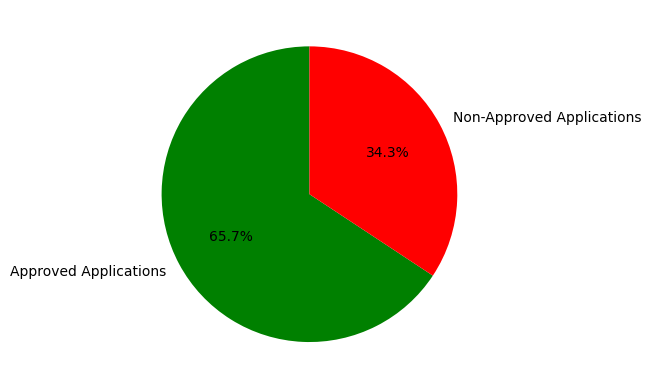

In [100]:
# 5. Functional Requirements - Data Analysis and Visualization for LOAN Application
# After the data is loaded into the database, the business analyst team wants to analyze and
#  visualize the data.
# Use Python libraries for the below requirements:

#Find and plot the percentage of applications approved for self-employed applicants.
# Note: Take a screenshot of the graph. 
approved_apps = loan_df.filter((loan_df.Self_Employed == 'Yes') & 
                      (loan_df.Application_Status == 'Y' ))
total_apps = loan_df.filter((loan_df.Self_Employed == 'Yes')).count()
app_percent = (approved_apps.count() / total_apps) * 100
labels = ['Approved Applications', 'Non-Approved Applications']
sizes = [app_percent, 100 - app_percent]
colors = ['green', 'red']
mp.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)                      
mp.show()    
#Find the percentage of rejection for married male applicants.
# Note: Take a screenshot of the graph.

#Find and plot the top three months with the largest transaction data.
# Note: Take a screenshot of the graph. 

#Find and plot which branch processed the highest total dollar value of healthcare transactions.
# Note: Take a screenshot of the graph. 

In [93]:
loan_df.filter((loan_df.Self_Employed == 'Yes') & 
                      (loan_df.Application_Status == 'Y' )).show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001011|                 Y|             1|         2|    Graduate|  Male|medium|    Yes|        Urban|          Yes|
|      LP001066|                 Y|             1|         0|    Graduate|  Male|medium|    Yes|    Semiurban|          Yes|
|      LP001136|                 Y|             1|         0|Not Graduate|  Male|medium|    Yes|        Urban|          Yes|
|      LP001238|                 Y|             1|        3+|Not Graduate|  Male|medium|    Yes|        Urban|          Yes|


In [92]:
# Assuming you have already loaded the loan application data into a DataFrame called loan_df

# Filter the DataFrame to include only self-employed applicants
self_employed_df = loan_df[loan_df['Self_Employed'] == 'Yes']

# Count the total number of applications for self-employed applicants
total_applications = len(self_employed_df)

# Count the number of approved applications for self-employed applicants
approved_applications = len(self_employed_df[self_employed_df['Application_Status'] == 'Y'])

# Calculate the percentage of applications approved for self-employed applicants
approval_percentage = (approved_applications / total_applications) * 100

# Create a pie chart to visualize the percentage of approved applications
labels = ['Approved', 'Not Approved']
sizes = [approval_percentage, 100 - approval_percentage]
colors = ['#66BB6A', '#EF5350']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Percentage of Applications Approved for Self-employed Applicants')
plt.show()

TypeError: object of type 'DataFrame' has no len()

In [68]:
#5th choice
#  Used to modify the existing account details of a customer.
def modify_cust_account(cust_ssn, cust_sql):
    #have to do cust_sql.columns instead of just cust_sql so when using column in the loops print f
    #it just prints its name instead of all the extra wonky stuff
    temp_sql = cust_sql
    for column in cust_sql.columns:
        user_input = input(f"Do you want to modify customer's {column} (y/n): ")
        if user_input.lower() == 'y':
            new_value = input(f'Enter the new value for {column}: ')
            temp_sql = temp_sql.withColumn(column, when(temp_sql.SSN == cust_ssn, new_value).otherwise(col(column)))
        else:
            continue
    modified_row =temp_sql.filter(temp_sql.SSN == cust_ssn)
    modified_row.show()
    # spark.catalog.uncacheTable("CDW_SAPP_CUSTOMER")
    spark.sql("DROP TABLE IF EXISTS CDW_SAPP_CUSTOMER")
    # Write the modified DataFrame back to the SQL database
    temp_sql.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",
                                     user="root",
                                     password="password",
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",
                                     dbtable="CDW_SAPP_CUSTOMER", 
                                     mode="overwrite").save()
modify_cust_account(123451364, cust_sql)

+----------------+------------+------------+------------------+-------------+----------+--------+----------+---------+-----------+---------+-------------------+
|  CREDIT_CARD_NO|   CUST_CITY|CUST_COUNTRY|        CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|MIDDLE_NAME|      SSN|FULL_STREET_ADDRESS|
+----------------+------------+------------+------------------+-------------+----------+--------+----------+---------+-----------+---------+-------------------+
|4210653320012911|ASDASDASDASD|   ASDASDASD|SBrady@example.com|(123)493-5814|        PA|   17201|     Sofia|    Brady|     gloria|123451364|  993,Cooper Street|
+----------------+------------+------------+------------------+-------------+----------+--------+----------+---------+-----------+---------+-------------------+



AnalysisException: Table or view 'CDW_SAPP_CUSTOMER' already exists. SaveMode: ErrorIfExists.

In [33]:
spark.sql("DROP TABLE IF EXISTS CDW_SAPP_CUSTOMER_MODIFIED")

DataFrame[]

In [14]:
spark.catalog.listDatabases()

[Database(name='default', catalog='spark_catalog', description='default database', locationUri='file:/C:/Users/Learner_9ZH3Z126/2023_data_engineering/SBA-350-Final_Project/spark-warehouse')]